# Моннар И. С. Задание №2. Линейная регрессия: построение, оценка адекватности и тюнинг

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Анализ временных рядов с помощью ЛМФМ

# Цель работы и постановка задачи

# Цель работы
Основной целью является построение линейной многофакторной модели (ЛМФМ) для анализа факторов, влияющих на отклик, и выполнения прогноза на основе новых данных. ЛМФМ позволяет исследовать зависимости между переменными, отбирать значимые факторы, оценивать адекватность модели и улучшать её качество.

# Постановка задачи
1. Считать временные ряды отклика (`y`) и факторов (`X`) из текстового файла.
2. Построить линейную модель и оценить её параметры.
3. Отобрать значимые факторы по критериям статистической значимости, корреляции между факторами и откликом.
4. Оценить адекватность модели с использованием коэффициента детерминации, F-статистики, RMSE и других показателей.
5. Выполнить прогнозирование с помощью построенной модели на новых данных, хранящихся в отдельном файле.

# Краткое описание процедуры построения и оценки ЛМФМ

# 1. Подготовка данных
- Загружаем данные из текстового файла в формате CSV.
- Разделяем их на отклик (`y`) и факторы (`X`).

# 2. Построение модели
- Используем метод наименьших квадратов для оценки параметров ЛМФМ с помощью библиотеки `statsmodels`.
- Включаем свободный член (константу) для корректного описания модели.

# 3. Отбор факторов
- Оцениваем значимость факторов по p-value с помощью уровня значимости, задаваемого пользователем.
- Рассчитываем коэффициенты корреляции:
  - Между факторами и откликом (`y`).
  - Между самими факторами для анализа мультиколлинеарности.
- Используем показатель VIF (Variance Inflation Factor) для количественного измерения мультиколлинеарности.

# 4. Оценка адекватности модели
- Рассчитываем коэффициент детерминации (ρ2), F-статистику, и их p-value для проверки значимости модели.
- Используем метрики ошибок, такие как RMSE (Root Mean Square Error) и среднюю относительную ошибку, для оценки качества прогнозирования.
- Вычисляем статистику Durbin-Watson для проверки автокорреляции остатков.

# 5. Визуализация результатов
- Строим графики истинных и предсказанных значений для визуального сравнения качества модели.
- Выводим матрицу корреляции факторов в виде тепловой карты.

# 6. Прогнозирование
- Выполняем прогноз на основе новых данных, которые пользователь предоставляет в отдельном файле.
- Сохраняем результаты в текстовом файле.

# 7. Итоги и интерпретация
- Формулируем выводы на основе значимости факторов и качества модели.
- Предлагаем рекомендации по дальнейшему улучшению модели: добавление лагов, изменение набора факторов и тюнинг гиперпараметров.

## Загрузка данных

In [85]:
def load_data(filepath):
    """Загрузка данных из текстового файла."""
    data = pd.read_excel(filepath, index_col=0)
    new_data = data.iloc[11:].drop(columns=['Общие затраты на ведение охотничьего хозяйства'])
    yytr = data.iloc[11:]['Общие затраты на ведение охотничьего хозяйства']
    old_data = data.iloc[:11]
    return old_data, new_data, yytr

In [86]:
data, new_data, yytr = load_data('/content/643_Российская_Федерация.xlsx')
data

,Общее количество охотпользователей,Общие затраты на ведение охотничьего хозяйства,Площадь закрепленных охотничьих угодий,Проведение учета численности охотничьих ресурсов,Биотехнические мероприятия по сохранению и воспроизводству охотничьих ресурсов - всего
2005,2006,1489211.70,626339.0,34277.30,224852.30
2006,2276,2002726.90,661850.0,40491.40,306683.00
2007,2810,2601075.29,686469.0,59231.30,431477.20
2008,2975,3339559.03,682284.0,70143.59,500151.79
2009,3189,3847372.99,698861.1,93547.10,607624.80
2010,3614,4515376.20,721479.6,90170.50,655318.40
2011,3908,5532088.80,762095.9,117267.50,743142.70
2012,3956,6195736.10,738112.1,151292.60,985652.70
2013,4033,6718304.20,724364.0,170781.90,1030807.69
2014,4182,7079133.00,728908.3,193572.70,968419.09


## Оценка параметров линейной модели

In [ ]:
def fit_linear_model(X, y):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    return model

In [ ]:
X = data.drop(columns=['Общие затраты на ведение охотничьего хозяйства'])
y = data['Общие затраты на ведение охотничьего хозяйства']
model = fit_linear_model(X, y)

## Отбор значимых факторов на основе p-value

In [ ]:
def select_significant_factors(model, significance_level):
    p_values = model.pvalues
    significant_factors = p_values[p_values < significance_level].index
    return significant_factors

In [ ]:
select_significant_factors(model, 0.05)

Index(['const', 'Общее количество охотпользователей',
       'Площадь закрепленных охотничьих угодий'],
      dtype='object')

## Расчет коэффициентов корреляции между факторами и откликом

In [ ]:
def calculate_correlations(data):
    return data.corr()

In [ ]:
calculate_correlations(data)

,Общее количество охотпользователей,Общие затраты на ведение охотничьего хозяйства,Площадь закрепленных охотничьих угодий,Проведение учета численности охотничьих ресурсов,Биотехнические мероприятия по сохранению и воспроизводству охотничьих ресурсов - всего
Общее количество охотпользователей,1.000000,0.976301,0.550450,0.939253,0.977437
Общие затраты на ведение охотничьего хозяйства,0.976301,1.000000,0.379517,0.958363,0.974314
Площадь закрепленных охотничьих угодий,0.550450,0.379517,1.000000,0.423928,0.508235
Проведение учета численности охотничьих ресурсов,0.939253,0.958363,0.423928,1.000000,0.965987
Биотехнические мероприятия по сохранению и воспроизводству охотничьих ресурсов - всего,0.977437,0.974314,0.508235,0.965987,1.000000


## Расчет VIF для факторов

In [ ]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [ ]:
calculate_vif(X)

,feature,VIF
0,Общее количество охотпользователей,522.106918
1,Площадь закрепленных охотничьих угодий,116.663315
2,Проведение учета численности охотничьих ресурсов,86.226526
3,Биотехнические мероприятия по сохранению и вос...,291.444876


## Оценка модели с использованием коэффициента детерминации, F-статистики и ошибки

In [ ]:
def evaluate_model(model, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    f_stat = model.fvalue
    p_value = model.f_pvalue
    dw_stat = durbin_watson(model.resid)
    return {
        'R2': r2,
        'RMSE': rmse,
        'F-statistic': f_stat,
        'p-value': p_value,
        'Durbin-Watson': dw_stat
    }

In [ ]:
evaluate_model(model, y, model.predict(sm.add_constant(X)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'R2': 0.9937669136806693,
 'RMSE': 200486.19251534852,
 'F-statistic': 398.5854128951715,
 'p-value': 5.615717451753941e-11,
 'Durbin-Watson': 2.1095271691578152}

## Предсказание на основе новых значений факторов

In [ ]:
def predict_new_data(model, new_data):
    return model.predict(sm.add_constant(new_data))

In [ ]:
predict_new_data(model, new_data)

,0
2016,8.261418e+06
2017,8.519531e+06
2018,8.857013e+06
2019,9.284760e+06


## График сравнения истинных и предсказанных значений

In [ ]:
def plot_results(y_true, y_pred, title="Результаты модели"):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Истинные значения', marker='o')
    plt.plot(y_pred, label='Предсказанные значения', marker='x')
    plt.legend()
    plt.title(title)
    plt.xlabel('Наблюдения')
    plt.ylabel('Отклик')
    plt.show()

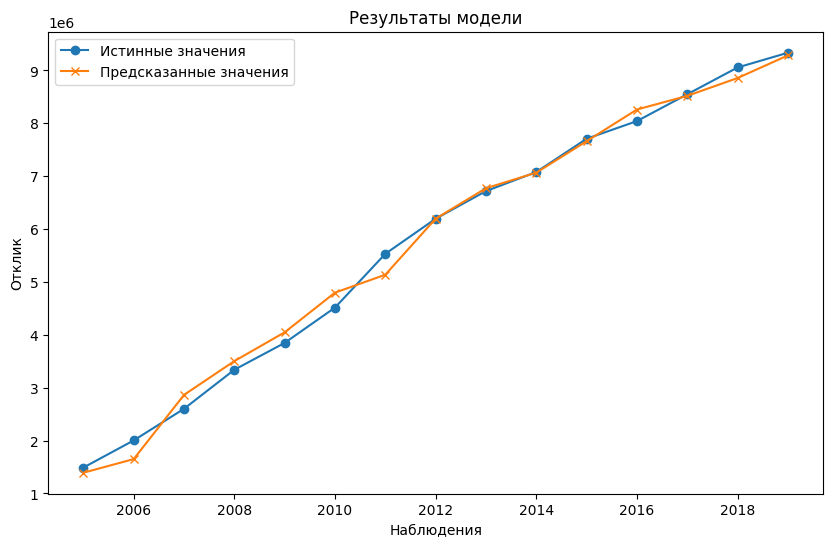

In [ ]:
plot_results(y, model.predict(sm.add_constant(X)))

## Функции создания лагов

In [ ]:
def create_lagged_features(data, lags):
    lagged_data = data.copy()
    for lag in range(1, lags + 1):
        for col in data.columns:
            lagged_data[f"{col}_lag{lag}"] = data[col].shift(lag)
    return lagged_data.dropna()

In [ ]:
def select_response_range(response, start, end):
    return response[start:end]

In [ ]:
def evaluate_model(model, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MSE": mse,
        "R-squared": model.rsquared
    }

## Объединение всех функций в единый программный код

In [88]:
def main():
    filepath = '/content/643_Российская_Федерация.xlsx'
    data, new_data, yytr = load_data(filepath)

    y = data['Общие затраты на ведение охотничьего хозяйства']
    X = data.drop(columns=['Общие затраты на ведение охотничьего хозяйства'])

    model = fit_linear_model(X, y)
    print(model.summary())

    significance_level = float(input("Введите уровень значимости для отбора факторов: "))
    significant_factors = select_significant_factors(model, significance_level)
    print("Значимые факторы:", significant_factors)

    X_selected = X[significant_factors]
    model_updated = fit_linear_model(X_selected, y)
    print(model_updated.summary())

    y_pred = model_updated.predict(sm.add_constant(X_selected))
    metrics = evaluate_model(model_updated, y, y_pred)
    print("Оценка модели:", metrics)

    plot_results(y, y_pred)

    predictions = predict_new_data(model_updated, sm.add_constant(new_data)[select_significant_factors(model, 0.05)])
    print("Предсказания:", predictions)

    plot_results(yytr, predictions)

    output_path = input("Введите путь для сохранения результатов: ")
    with open(output_path, 'w') as f:
        f.write("Оценка модели:\n")
        f.write(str(metrics))
        f.write("\nПредсказания:\n")
        f.write(predictions.to_string())

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)


                                          OLS Regression Results                                          
Dep. Variable:     Общие затраты на ведение охотничьего хозяйства   R-squared:                       0.995
Model:                                                        OLS   Adj. R-squared:                  0.992
Method:                                             Least Squares   F-statistic:                     315.0
Date:                                            Wed, 11 Dec 2024   Prob (F-statistic):           4.24e-07
Time:                                                    15:22:18   Log-Likelihood:                -146.05
No. Observations:                                              11   AIC:                             302.1
Df Residuals:                                                   6   BIC:                             304.1
Df Model:                                                       4                                         
Covariance Type:                     

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)


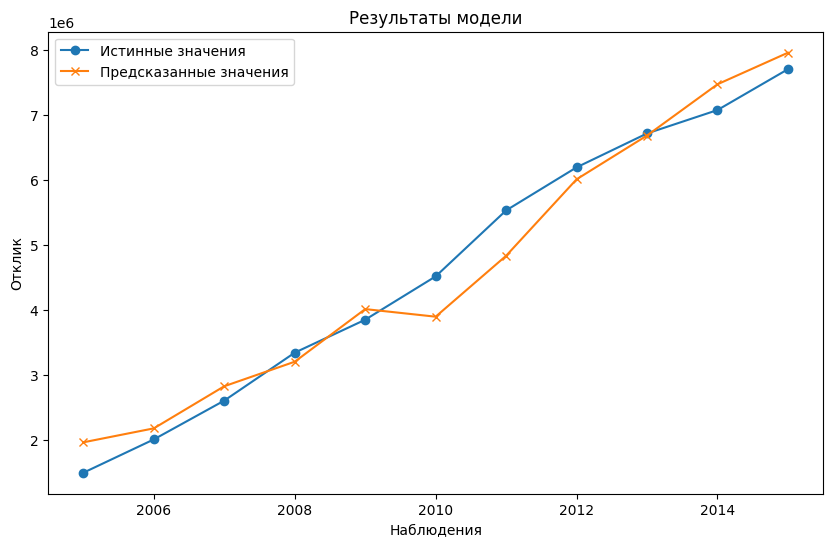

Предсказания: 2016    8.462510e+06
2017    7.032410e+06
2018    7.436972e+06
2019    7.412625e+06
dtype: float64


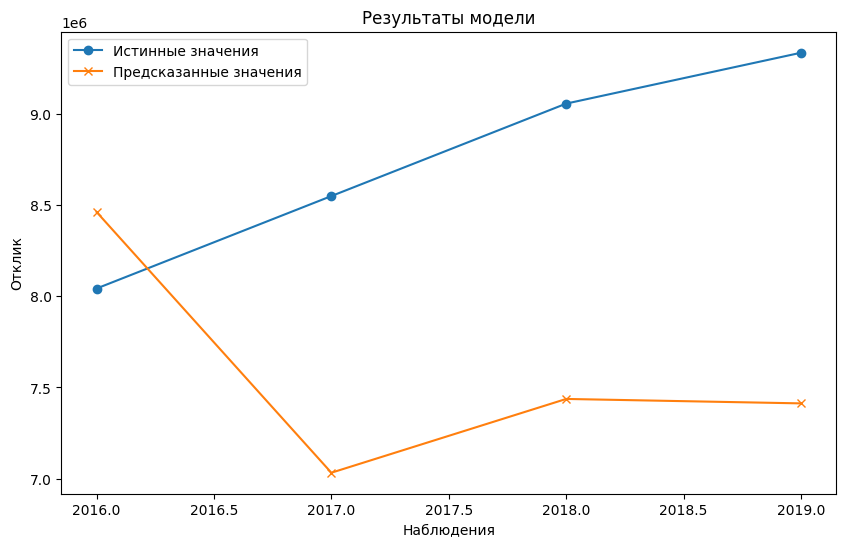

Введите путь для сохранения результатов: results.txt


In [89]:
main()